In [1]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.settings import QiskitNatureSettings

QiskitNatureSettings.use_pauli_sum_op = False

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Statevector

import numpy as np
import matplotlib.pyplot as plt

## Exercise

The Hubbard model is a prototypical model in condensed matter physics that describes electrons moving on a lattice. In its simplest form, each lattice site can be occupied by two electrons, one with spin up, one with spin down.
The Hamiltonian reads
$$H = - t \sum_{i,\sigma} a^\dagger_{i,\sigma} a_{i+1,\sigma} + a^\dagger_{i+1,\sigma} a_{i,\sigma} + U \sum_i n_{i, \uparrow} n_{i, \downarrow} \ ,$$
where the $i$ index runs over all sites of the lattice and $\sigma \in \{ \uparrow, \downarrow \}$ denotes the spin of the electrons. $a^\dagger, a$ are creation and annihilation operators, respectively, and $n_{i, \sigma} =  a^\dagger_{i,\sigma} a_{i,\sigma}$ is the corresponding number operator.
The first term $\propto t$ is the kinetic energy term and is responsible for electrons hopping between neighboring lattice sites. The second term $\propto U$ corresponds to the potential energy mediated by the Coulomb repulsion, meaning electrons will pay an energy penalty if they occupy the same site.

You are given the Hamiltonian of a 2-site Hubbard model (corresponding to four qubits since each site can have spin up and spin down) in the format of a dictionary like we implemented in last week's exercise.
The qubit register is structured such that $\bigotimes_i | q_{i,\uparrow} q_{i,\downarrow} \rangle$. In our 2-site case, this means $|q_{0, \uparrow} q_{0, \downarrow} q_{1, \uparrow} q_{1, \downarrow}  \rangle$, i.e. the first two qubits encode the occupation of site-0 with a spin-up or -down electron, respectively, while the last two qubits encode the occupation of site-1 with a spin-up or -down electron.
- Map the operator to Pauli-strings using `qiskit-nature`'s built-in operator class `FermionicOp` and the `JordanWignerMapper`
- Then compute the time evolution using Trotter circuits generated with Qiskit's `PauliEvolutionGate`
    - initializing the system in the localized (on site 0) state $|1100 \rangle$
    - for final time $t=5$ and $N_t=50$ time steps
-  Compute the following two observables for every time step (you can simply do this by evaluating exact statevectors)
    - the overlap with the localized (initial state) state
    - the sum of the number operators on site 0 and 1, $n_0 = n_{0, \uparrow} + n_{0, \downarrow}$
- Plot the results for both quantities

In [12]:
num_orbitals = 4
op_dict = {
    "+_2 -_0": -1,
    "+_0 -_2": -1,
    "+_3 -_1": -1,
    "+_1 -_3": -1,
    "+_0 -_0 +_1 -_1": 0.5,
    "+_2 -_2 +_3 -_3": 0.5,
}

## Solution

In [13]:
sec_q_op = FermionicOp(op_dict)

In [14]:
mapper = JordanWignerMapper()

pauli_strings = mapper.map(sec_q_op, register_length=num_orbitals)

print(pauli_strings)

SparsePauliOp(['IXZX', 'IYZY', 'XZXI', 'YZYI', 'IIII', 'IIZI', 'IIIZ', 'IIZZ', 'ZIII', 'IZII', 'ZZII'],
              coeffs=[-0.5  +0.j, -0.5  +0.j, -0.5  +0.j, -0.5  +0.j,  0.25 +0.j, -0.125+0.j,
 -0.125+0.j,  0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j])


In [52]:
t_final = 5
N_t = 50
dt = t_final / N_t

psi_init = Statevector.from_label("0011")

evo_gate = PauliEvolutionGate(pauli_strings, time=dt)
qreg = QuantumRegister(num_orbitals)

## initialize the quantum circuit
qc = QuantumCircuit(qreg)
qc.initialize(psi_init.data, qreg)


overlaps = []
sum_of_ops = []
times = np.linspace(0, t_final, N_t + 1)
for t in times:
    qc.append(evo_gate, qargs=qreg)
    qc.barrier()

    psi_t = Statevector(qc)
    overlap = psi_t.inner(psi_init)
    
    overlaps.append(np.abs(overlap) ** 2)

    print(psi_t.probabilities_dict())
    occupation_0 = psi_t.probabilities_dict()['1100']
    occupation_0 += psi_t.probabilities_dict()['1001']
    occupation_1 = psi_t.probabilities_dict()['0110']
    occupation_1 += psi_t.probabilities_dict()['0011']
    num_operator_sum = occupation_0 + occupation_1
    occupation_1 = psi_t.probabilities_dict()[('1', '0')]
    num_operator_sum = occupation_0 + occupation_1
    
    sum_of_ops.append((overlap, num_operator_sum))
    

{'0000': 6.224664490312708e-66, '0001': 3.173395501733463e-34, '0010': 7.251896661013336e-34, '0011': 0.9801659131709792, '0100': 5.348422037242055e-36, '0101': 7.805935746934762e-66, '0110': 0.009867375749639348, '0111': 1.619208409228566e-33, '1000': 7.300518033755703e-36, '1001': 0.009867375749639345, '1010': 1.611298329267121e-67, '1011': 5.148073977215314e-34, '1100': 9.933532973981963e-05, '1101': 1.6300646223398064e-35, '1110': 2.3621359615061944e-35, '1111': 9.782844140675505e-67}


KeyError: ('1', '1')

ValueError: x and y must have same first dimension, but have shapes (51,) and (1,)

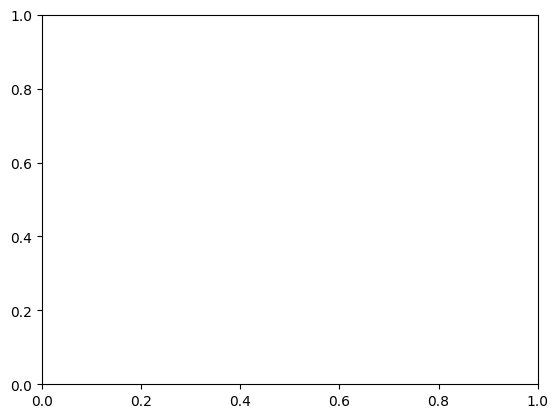

In [49]:
plt.plot(times, overlaps)
plt.xlabel("Time")
plt.ylabel("Overlap")

In [ ]:
# Sum of operators at 